## **1. Importación de librerias y datos**

In [1]:
import pandas as pd

data = pd.read_csv("listings_cleaned.csv")
data['review_scores'] = data['review_scores'].astype(float)
data.head()

,id,last_scraped,name,host_id,host_name,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,...,calculated_host_listings_count_shared_rooms,reviews_per_month,review_scores,days_since_last_review,price_per_person,price_category,property_type_simple,occupancy_rate,is_entire_place,capacity_category
0,31840,2025-06-19,Residenza Martin Classic room,380378,Andrea,2011-02-07,within an hour,0.99,1.0,Sin registro,...,0,0.85,4.791429,177.0,65.000000,Medio,Apartment,0.410959,False,Pareja
1,32180,2025-06-19,Charming Gem - Oltrarno City centre,13925330,Cesare,2014-04-05,within a day,0.83,0.75,False,...,0,0.22,4.792857,198.0,28.000000,Medio,Apartment,0.230137,True,Pequeño
2,39822,2025-06-19,Apartment Santa Monaca Oltrarno old town,154769,Matilde,2010-06-29,within an hour,1.0,1.0,True,...,0,0.19,4.584286,198.0,24.250000,Económico,Apartment,0.109589,True,Pequeño
3,44781,2025-06-19,Stylish Terrace on Boboli Gardens,33210,Rocco,2009-08-22,within an hour,1.0,0.98,True,...,0,2.47,4.881429,175.0,43.250000,Medio,Apartment,0.575342,True,Pequeño
4,46520,2025-06-19,Residenza Martin: Superior room,380378,Andrea,2011-02-07,within an hour,0.99,1.0,Sin registro,...,0,0.76,4.857143,176.0,41.666667,Medio,Apartment,0.509589,False,Pequeño


## **2. Construcción del target (para clasificación)**
Este target es sólido para un producto analítico porque combina desempeño real (ocupación) y percepción del huésped (calificación).

In [2]:
df = data.copy()

# Criterios recomendados
df["recommended"] = (
    (df["occupancy_rate"] >= 0.65) &
    (df["review_scores"] >= 4.6)
).astype(int)

df["recommended"].value_counts()

recommended
0    8972
1    2011
Name: count, dtype: int64

## **3. Selección de variables y preparación**

In [3]:
num_features = [
    "accommodates", "bedrooms", "beds", "latitude", "longitude",
    "occupancy_rate", "price_per_person", "minimum_nights",
    "maximum_nights", "number_of_reviews", "host_total_listings_count",
    "review_scores", "reviews_per_month"
]

df["bedrooms"] = pd.to_numeric(df["bedrooms"], errors="coerce").fillna(0)
df["beds"] = pd.to_numeric(df["beds"], errors="coerce").fillna(0)

# Variables categóricas recomendadas
cat_features = ["neighbourhood_cleansed", "property_type_simple", "host_is_superhost"]
df = pd.get_dummies(df, columns=cat_features, drop_first=True)

# DF final para modelos
feature_cols = num_features + [c for c in df.columns if any(feat in c for feat in cat_features)]

X = df[feature_cols].values
y_reg = df["price"].values
y_clf = df["recommended"].values

## **4. División de los datos en train/test**

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# División
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)
_, _, y_train_clf, y_test_clf = train_test_split(X, y_clf, test_size=0.2, random_state=42)

# Escalamiento
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## **5. Creación de los modelos**
### Modelo de regresión

In [160]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Modelo de regresión
reg_model = keras.Sequential([
    layers.Dense(235, activation="relu", input_shape=(X_train.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(120, activation="relu"),
    layers.Dense(1)
])

reg_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00047),
    loss="mse",
    metrics=["mae"]
)

history_reg = reg_model.fit(
    X_train, y_train_reg,
    validation_split=0.2,
    epochs=50,
    batch_size=16,
    verbose=1
)

Epoch 1/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 564796.1875 - mae: 195.8155 - val_loss: 543506.2500 - val_mae: 162.9002
Epoch 2/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 446729.9062 - mae: 182.4706 - val_loss: 433146.5000 - val_mae: 200.7652
Epoch 3/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 361337.0000 - mae: 190.0434 - val_loss: 333393.1250 - val_mae: 188.6350
Epoch 4/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 259820.5625 - mae: 166.9902 - val_loss: 250172.9375 - val_mae: 159.5634
Epoch 5/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 177823.9219 - mae: 134.1371 - val_loss: 232202.8594 - val_mae: 137.6719
Epoch 6/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 127065.5078 - mae: 115.3097 - val_loss: 264755.0625 - val_mae: 127.4839
Epoch 7/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 112049.8750 - mae: 110.4522 - val_loss: 264210.4062 - val_mae: 106.9707
Epoch 8/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 99715.5391 - mae

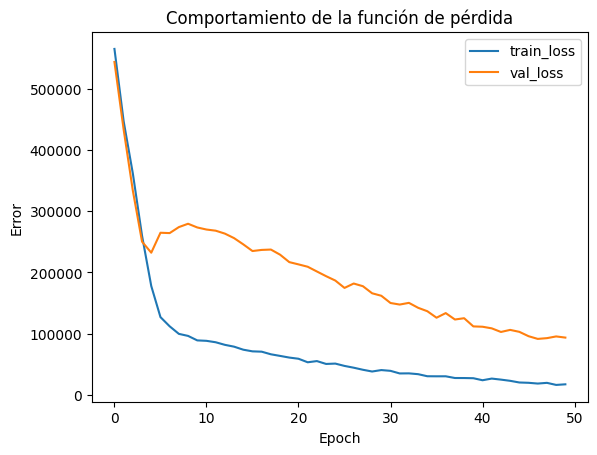

In [161]:
import matplotlib.pyplot as plt

plt.plot(history_reg.history['loss'], label='train_loss')
plt.plot(history_reg.history['val_loss'], label='val_loss')

plt.title("Comportamiento de la función de pérdida")
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()

### Modelo de clasificación

In [149]:
clf_model = keras.Sequential([
    layers.Dense(33, activation="relu", input_shape=(X_train.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(191, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

clf_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.000986),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history_clf = clf_model.fit(
    X_train, y_train_clf,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    verbose=1
)

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8741 - loss: 0.3176 - val_accuracy: 0.9329 - val_loss: 0.1649
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9234 - loss: 0.1820 - val_accuracy: 0.9516 - val_loss: 0.1321
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9405 - loss: 0.1507 - val_accuracy: 0.9608 - val_loss: 0.1150
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9428 - loss: 0.1387 - val_accuracy: 0.9642 - val_loss: 0.1044
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9496 - loss: 0.1167 - val_accuracy: 0.9676 - val_loss: 0.0963
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9555 - loss: 0.1107 - val_accuracy: 0.9681 - val_loss: 0.0870
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9577 - loss: 0.1074 - val_accuracy: 0.9721 - val_loss: 0.0793
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9609 - loss: 0.0961 - val_accuracy: 0.

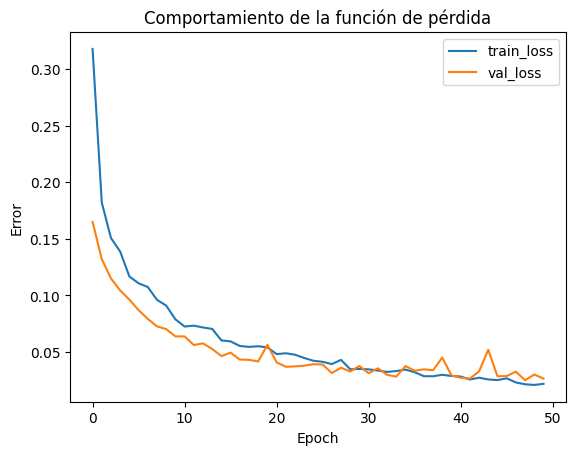

In [150]:
import matplotlib.pyplot as plt

plt.plot(history_clf.history['loss'], label='train_loss')
plt.plot(history_clf.history['val_loss'], label='val_loss')

plt.title("Comportamiento de la función de pérdida")
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()

## **6. Evaluación de los modelos**

In [162]:
from sklearn.metrics import mean_absolute_error, r2_score, classification_report, confusion_matrix

# Regresión
y_pred_reg = reg_model.predict(X_test).flatten()
print("MAE:", mean_absolute_error(y_test_reg, y_pred_reg))
print("R2:", r2_score(y_test_reg, y_pred_reg))

# Clasificación
y_pred_clf = (clf_model.predict(X_test) > 0.65).astype(int)
print(classification_report(y_test_clf, y_pred_clf))
print(confusion_matrix(y_test_clf, y_pred_clf))

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAE: 33.02746795859183
R2: 0.9640669798931386
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1811
           1       0.97      0.95      0.96       386

    accuracy                           0.99      2197
   macro avg       0.98      0.97      0.98      2197
weighted avg       0.99      0.99      0.99      2197

[[1800   11]
 [  18  368]]


La matriz de confusión tiene la forma:

TN  FP  
FN  TP

Donde:

TN = verdaderos negativos  
TP = verdaderos positivos  
FP = falsos positivos (error tipo I)  
FN = falsos negativos (error tipo II)

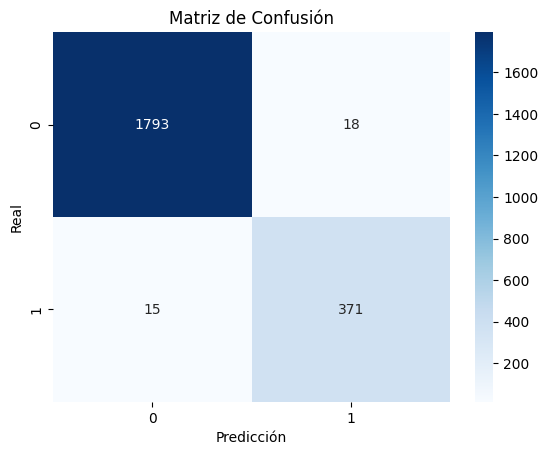

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Matriz de confusión
matriz_confusion = confusion_matrix(y_test_clf, y_pred_clf)

# Visualización de la matriz de confusión
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

## **7. Exportación para MLflow**

In [65]:
reg_model.save("regression_model.h5")
clf_model.save("classification_model.h5")

## **8. Búsqueda amplia de hiperparámetros**

In [34]:
import optuna

c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Modelo de regresión

In [42]:
def create_reg_model(trial, input_dim):

    n_layers = trial.suggest_int("n_layers", 1, 3)

    model = keras.Sequential()
    
    # Primera capa
    units = trial.suggest_int("units_l0", 32, 256)

    model.add(layers.Dense(units, activation="relu", input_shape=(input_dim,)))

    # Capas adicionales
    for i in range(1, n_layers):
        units_i = trial.suggest_int(f"units_l{i}", 32, 256)
        model.add(layers.Dense(units_i, activation="relu"))

    # Capa de salida
    model.add(layers.Dense(1))

    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss="mse",
                  metrics=["mae"])
    
    return model

In [43]:
def objective_reg(trial):

    model = create_reg_model(trial, input_dim=X_train.shape[1])

    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    history = model.fit(
        X_train, y_train_reg,
        validation_split=0.2,
        epochs=50,
        batch_size=batch_size,
        verbose=0
    )

    # Evaluación
    y_pred = model.predict(X_test).flatten()
    mae = mean_absolute_error(y_test_reg, y_pred)

    return mae

In [44]:
study_reg = optuna.create_study(direction="minimize")
study_reg.optimize(objective_reg, n_trials=30)

[I 2025-11-29 17:33:23,323] A new study created in memory with name: no-name-2927e082-41e4-4c7a-b050-bfb6744bb3b5
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-11-29 17:34:35,963] Trial 0 finished with value: 106.43817059685547 and parameters: {'n_layers': 3, 'units_l0': 37, 'units_l1': 74, 'units_l2': 200, 'lr': 3.845722905381419e-05, 'batch_size': 16}. Best is trial 0 with value: 106.43817059685547.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 17:35:45,014] Trial 1 finished with value: 25.469686590057098 and parameters: {'n_layers': 2, 'units_l0': 236, 'units_l1': 139, 'lr': 0.0010915459060648002, 'batch_size': 16}. Best is trial 1 with value: 25.469686590057098.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-11-29 17:36:16,126] Trial 2 finished with value: 65.58620088850307 and parameters: {'n_layers': 1, 'units_l0': 70, 'lr': 0.007223166874619399, 'batch_size': 32}. Best is trial 1 with value: 25.469686590057098.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 17:37:13,536] Trial 3 finished with value: 181.81393059872474 and parameters: {'n_layers': 1, 'units_l0': 255, 'lr': 2.729705713560186e-05, 'batch_size': 16}. Best is trial 1 with value: 25.469686590057098.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 17:38:25,276] Trial 4 finished with value: 41.4242048523998 and parameters: {'n_layers': 3, 'units_l0': 135, 'units_l1': 245, 'units_l2': 196, 'lr': 0.00010693749805584914, 'batch_size': 16}. Best is trial 1 with value: 25.469686590057098.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 17:38:54,561] Trial 5 finished with value: 161.62580044745965 and parameters: {'n_layers': 1, 'units_l0': 81, 'lr': 0.0003045295586104532, 'batch_size': 32}. Best is trial 1 with value: 25.469686590057098.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 17:39:26,023] Trial 6 finished with value: 93.31941718061132 and parameters: {'n_layers': 1, 'units_l0': 81, 'lr': 0.0007134093538835875, 'batch_size': 32}. Best is trial 1 with value: 25.469686590057098.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 17:39:59,349] Trial 7 finished with value: 72.99423863522074 and parameters: {'n_layers': 2, 'units_l0': 137, 'units_l1': 163, 'lr': 0.002358416022393591, 'batch_size': 32}. Best is trial 1 with value: 25.469686590057098.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-11-29 17:40:57,777] Trial 8 finished with value: 64.59129963238021 and parameters: {'n_layers': 1, 'units_l0': 172, 'lr': 0.0023035853683765605, 'batch_size': 16}. Best is trial 1 with value: 25.469686590057098.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 17:42:00,983] Trial 9 finished with value: 64.39891330198532 and parameters: {'n_layers': 1, 'units_l0': 82, 'lr': 0.0017650821766557144, 'batch_size': 16}. Best is trial 1 with value: 25.469686590057098.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 17:42:24,010] Trial 10 finished with value: 58.287417150976225 and parameters: {'n_layers': 2, 'units_l0': 255, 'units_l1': 131, 'lr': 0.00025682166453333885, 'batch_size': 64}. Best is trial 1 with value: 25.469686590057098.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 17:43:35,405] Trial 11 finished with value: 48.91743555272988 and parameters: {'n_layers': 3, 'units_l0': 178, 'units_l1': 250, 'units_l2': 89, 'lr': 0.00011691857470179879, 'batch_size': 16}. Best is trial 1 with value: 25.469686590057098.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-11-29 17:44:02,376] Trial 12 finished with value: 194.26749470519326 and parameters: {'n_layers': 3, 'units_l0': 209, 'units_l1': 246, 'units_l2': 249, 'lr': 1.0692989968393557e-05, 'batch_size': 64}. Best is trial 1 with value: 25.469686590057098.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 17:45:02,605] Trial 13 finished with value: 77.72539466460272 and parameters: {'n_layers': 2, 'units_l0': 124, 'units_l1': 169, 'lr': 9.356225945326863e-05, 'batch_size': 16}. Best is trial 1 with value: 25.469686590057098.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 17:46:02,002] Trial 14 finished with value: 28.76376756190114 and parameters: {'n_layers': 2, 'units_l0': 202, 'units_l1': 109, 'lr': 0.0009147895890759092, 'batch_size': 16}. Best is trial 1 with value: 25.469686590057098.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 17:47:01,505] Trial 15 finished with value: 45.942762956002866 and parameters: {'n_layers': 2, 'units_l0': 219, 'units_l1': 95, 'lr': 0.0008363061033737101, 'batch_size': 16}. Best is trial 1 with value: 25.469686590057098.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 17:47:19,220] Trial 16 finished with value: 44.286980575249856 and parameters: {'n_layers': 2, 'units_l0': 219, 'units_l1': 41, 'lr': 0.008780062696182284, 'batch_size': 64}. Best is trial 1 with value: 25.469686590057098.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 17:48:17,175] Trial 17 finished with value: 37.03838281803474 and parameters: {'n_layers': 2, 'units_l0': 181, 'units_l1': 124, 'lr': 0.0006914892401837639, 'batch_size': 16}. Best is trial 1 with value: 25.469686590057098.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 17:49:19,992] Trial 18 finished with value: 26.700673900737943 and parameters: {'n_layers': 2, 'units_l0': 199, 'units_l1': 188, 'lr': 0.004327105313258937, 'batch_size': 16}. Best is trial 1 with value: 25.469686590057098.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-11-29 17:49:39,436] Trial 19 finished with value: 41.79631919148948 and parameters: {'n_layers': 2, 'units_l0': 236, 'units_l1': 203, 'lr': 0.0043618421278387946, 'batch_size': 64}. Best is trial 1 with value: 25.469686590057098.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 17:50:35,733] Trial 20 finished with value: 29.079583804825518 and parameters: {'n_layers': 3, 'units_l0': 159, 'units_l1': 197, 'units_l2': 60, 'lr': 0.003301693440362713, 'batch_size': 16}. Best is trial 1 with value: 25.469686590057098.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 17:51:27,625] Trial 21 finished with value: 38.83404492371507 and parameters: {'n_layers': 2, 'units_l0': 198, 'units_l1': 101, 'lr': 0.0011314246350532097, 'batch_size': 16}. Best is trial 1 with value: 25.469686590057098.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 17:52:21,000] Trial 22 finished with value: 47.653068687354754 and parameters: {'n_layers': 2, 'units_l0': 235, 'units_l1': 158, 'lr': 0.0012576124379418555, 'batch_size': 16}. Best is trial 1 with value: 25.469686590057098.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 17:53:14,100] Trial 23 finished with value: 42.27495937299663 and parameters: {'n_layers': 2, 'units_l0': 200, 'units_l1': 195, 'lr': 0.00047338222061344803, 'batch_size': 16}. Best is trial 1 with value: 25.469686590057098.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 17:54:06,718] Trial 24 finished with value: 24.015714443755463 and parameters: {'n_layers': 2, 'units_l0': 235, 'units_l1': 120, 'lr': 0.004724312284964072, 'batch_size': 16}. Best is trial 24 with value: 24.015714443755463.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 17:55:03,459] Trial 25 finished with value: 37.710017163915204 and parameters: {'n_layers': 2, 'units_l0': 234, 'units_l1': 148, 'lr': 0.005622484594622298, 'batch_size': 16}. Best is trial 24 with value: 24.015714443755463.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 17:56:00,250] Trial 26 finished with value: 41.51554219832353 and parameters: {'n_layers': 3, 'units_l0': 238, 'units_l1': 180, 'units_l2': 119, 'lr': 0.009920346599611335, 'batch_size': 16}. Best is trial 24 with value: 24.015714443755463.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-11-29 17:57:06,719] Trial 27 finished with value: 26.956200648721477 and parameters: {'n_layers': 2, 'units_l0': 222, 'units_l1': 220, 'lr': 0.0036231825240895296, 'batch_size': 16}. Best is trial 24 with value: 24.015714443755463.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 17:57:27,545] Trial 28 finished with value: 36.71264540654017 and parameters: {'n_layers': 2, 'units_l0': 190, 'units_l1': 74, 'lr': 0.001967466368934707, 'batch_size': 64}. Best is trial 24 with value: 24.015714443755463.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 17:57:58,006] Trial 29 finished with value: 38.045392442303026 and parameters: {'n_layers': 3, 'units_l0': 158, 'units_l1': 135, 'units_l2': 156, 'lr': 0.005736817276755231, 'batch_size': 32}. Best is trial 24 with value: 24.015714443755463.


In [45]:
best_params_reg = study_reg.best_params
best_params_reg

{'n_layers': 2,
 'units_l0': 235,
 'units_l1': 120,
 'lr': 0.004724312284964072,
 'batch_size': 16}

### Modelo de regresión

In [48]:
def create_clf_model(trial, input_dim):

    n_layers = trial.suggest_int("n_layers", 1, 3)

    model = keras.Sequential()

    units = trial.suggest_int("units_l0", 32, 256)

    model.add(layers.Dense(units, activation="relu", input_shape=(input_dim,)))


    for i in range(1, n_layers):
        units_i = trial.suggest_int(f"units_l{i}", 32, 256)
        model.add(layers.Dense(units_i, activation="relu"))


    model.add(layers.Dense(1, activation="sigmoid"))

    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    
    return model

In [51]:
from sklearn.metrics import f1_score

def objective_clf(trial):

    model = create_clf_model(trial, input_dim=X_train.shape[1])

    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    history = model.fit(
        X_train, y_train_clf,
        validation_split=0.2,
        epochs=40,
        batch_size=batch_size,
        verbose=0
    )

    # Evaluación
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    f1 = f1_score(y_test_clf, y_pred)

    # Para Optuna: queremos maximizar F1 → lo multiplicamos por -1
    return -f1

In [52]:
study_clf = optuna.create_study(direction="minimize")
study_clf.optimize(objective_clf, n_trials=30)

[I 2025-11-29 18:11:58,760] A new study created in memory with name: no-name-3de0081d-5178-487b-a7f3-89411a69459d


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 18:12:35,338] Trial 0 finished with value: -0.9465838509316771 and parameters: {'n_layers': 2, 'units_l0': 200, 'units_l1': 128, 'lr': 2.8349863404040848e-05, 'batch_size': 16}. Best is trial 0 with value: -0.9465838509316771.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-11-29 18:13:09,148] Trial 1 finished with value: -0.9692307692307692 and parameters: {'n_layers': 1, 'units_l0': 56, 'lr': 0.0029247994060376523, 'batch_size': 16}. Best is trial 1 with value: -0.9692307692307692.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 18:13:31,469] Trial 2 finished with value: -0.9533417402269861 and parameters: {'n_layers': 3, 'units_l0': 162, 'units_l1': 85, 'units_l2': 229, 'lr': 0.004128934448860948, 'batch_size': 32}. Best is trial 1 with value: -0.9692307692307692.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 18:14:09,692] Trial 3 finished with value: -0.9533678756476683 and parameters: {'n_layers': 3, 'units_l0': 198, 'units_l1': 79, 'units_l2': 46, 'lr': 0.0008407783313473558, 'batch_size': 16}. Best is trial 1 with value: -0.9692307692307692.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 18:14:23,000] Trial 4 finished with value: -0.9668367346938775 and parameters: {'n_layers': 2, 'units_l0': 72, 'units_l1': 254, 'lr': 0.0017978454452059643, 'batch_size': 64}. Best is trial 1 with value: -0.9692307692307692.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 18:14:46,170] Trial 5 finished with value: -0.951188986232791 and parameters: {'n_layers': 3, 'units_l0': 163, 'units_l1': 159, 'units_l2': 191, 'lr': 0.0005829534727383183, 'batch_size': 32}. Best is trial 1 with value: -0.9692307692307692.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-11-29 18:15:19,936] Trial 6 finished with value: -0.9575 and parameters: {'n_layers': 1, 'units_l0': 107, 'lr': 0.00011787708557066028, 'batch_size': 16}. Best is trial 1 with value: -0.9692307692307692.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-11-29 18:15:32,048] Trial 7 finished with value: -0.7897574123989218 and parameters: {'n_layers': 1, 'units_l0': 85, 'lr': 2.1198007277524784e-05, 'batch_size': 64}. Best is trial 1 with value: -0.9692307692307692.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-11-29 18:16:08,464] Trial 8 finished with value: -0.9451371571072319 and parameters: {'n_layers': 1, 'units_l0': 161, 'lr': 4.069664527472569e-05, 'batch_size': 16}. Best is trial 1 with value: -0.9692307692307692.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-11-29 18:16:40,344] Trial 9 finished with value: -0.9541984732824428 and parameters: {'n_layers': 2, 'units_l0': 133, 'units_l1': 219, 'lr': 0.0021927438141225663, 'batch_size': 32}. Best is trial 1 with value: -0.9692307692307692.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 18:17:32,405] Trial 10 finished with value: -0.9434954007884363 and parameters: {'n_layers': 1, 'units_l0': 38, 'lr': 0.005948655235482304, 'batch_size': 16}. Best is trial 1 with value: -0.9692307692307692.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 18:17:50,844] Trial 11 finished with value: -0.9693877551020408 and parameters: {'n_layers': 2, 'units_l0': 37, 'units_l1': 253, 'lr': 0.0016397915332839316, 'batch_size': 64}. Best is trial 11 with value: -0.9693877551020408.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 18:18:09,270] Trial 12 finished with value: -0.9704749679075738 and parameters: {'n_layers': 2, 'units_l0': 33, 'units_l1': 191, 'lr': 0.009863018005431611, 'batch_size': 64}. Best is trial 12 with value: -0.9704749679075738.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 18:18:29,527] Trial 13 finished with value: -0.9601029601029601 and parameters: {'n_layers': 2, 'units_l0': 256, 'units_l1': 200, 'lr': 0.007943038002754168, 'batch_size': 64}. Best is trial 12 with value: -0.9704749679075738.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 18:18:46,241] Trial 14 finished with value: -0.9535759096612296 and parameters: {'n_layers': 2, 'units_l0': 33, 'units_l1': 251, 'lr': 0.00023078168481698738, 'batch_size': 64}. Best is trial 12 with value: -0.9704749679075738.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 18:19:02,058] Trial 15 finished with value: -0.9536921151439299 and parameters: {'n_layers': 2, 'units_l0': 108, 'units_l1': 179, 'lr': 0.009056601222137143, 'batch_size': 64}. Best is trial 12 with value: -0.9704749679075738.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 18:19:20,372] Trial 16 finished with value: -0.9665809768637532 and parameters: {'n_layers': 2, 'units_l0': 66, 'units_l1': 221, 'lr': 0.0009300600240214986, 'batch_size': 64}. Best is trial 12 with value: -0.9704749679075738.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 18:19:37,051] Trial 17 finished with value: -0.9656050955414013 and parameters: {'n_layers': 3, 'units_l0': 93, 'units_l1': 38, 'units_l2': 90, 'lr': 0.0003238566070383112, 'batch_size': 64}. Best is trial 12 with value: -0.9704749679075738.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 18:19:54,409] Trial 18 finished with value: -0.9664948453608248 and parameters: {'n_layers': 3, 'units_l0': 50, 'units_l1': 124, 'units_l2': 133, 'lr': 0.0015911923391196358, 'batch_size': 64}. Best is trial 12 with value: -0.9704749679075738.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 18:20:10,278] Trial 19 finished with value: -0.9414893617021277 and parameters: {'n_layers': 2, 'units_l0': 124, 'units_l1': 191, 'lr': 0.0038423437405756384, 'batch_size': 64}. Best is trial 12 with value: -0.9704749679075738.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 18:20:25,712] Trial 20 finished with value: -0.8643852978453739 and parameters: {'n_layers': 2, 'units_l0': 77, 'units_l1': 226, 'lr': 1.0646926634997526e-05, 'batch_size': 64}. Best is trial 12 with value: -0.9704749679075738.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 18:21:05,986] Trial 21 finished with value: -0.9609079445145019 and parameters: {'n_layers': 1, 'units_l0': 54, 'lr': 0.0033647275613407648, 'batch_size': 16}. Best is trial 12 with value: -0.9704749679075738.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 18:21:45,026] Trial 22 finished with value: -0.9667519181585678 and parameters: {'n_layers': 1, 'units_l0': 32, 'lr': 0.0025480189543966333, 'batch_size': 16}. Best is trial 12 with value: -0.9704749679075738.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 18:22:07,272] Trial 23 finished with value: -0.9670050761421319 and parameters: {'n_layers': 1, 'units_l0': 56, 'lr': 0.0012024552237774387, 'batch_size': 32}. Best is trial 12 with value: -0.9704749679075738.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 18:22:20,990] Trial 24 finished with value: -0.9638242894056848 and parameters: {'n_layers': 1, 'units_l0': 51, 'lr': 0.005223793645263857, 'batch_size': 64}. Best is trial 12 with value: -0.9704749679075738.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 18:23:04,394] Trial 25 finished with value: -0.9639175257731959 and parameters: {'n_layers': 2, 'units_l0': 93, 'units_l1': 165, 'lr': 0.0004869526491667274, 'batch_size': 16}. Best is trial 12 with value: -0.9704749679075738.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 18:23:22,821] Trial 26 finished with value: -0.963151207115629 and parameters: {'n_layers': 3, 'units_l0': 69, 'units_l1': 235, 'units_l2': 253, 'lr': 0.009423739237826037, 'batch_size': 64}. Best is trial 12 with value: -0.9704749679075738.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 18:23:37,800] Trial 27 finished with value: -0.9539641943734015 and parameters: {'n_layers': 2, 'units_l0': 45, 'units_l1': 200, 'lr': 0.002602719097721325, 'batch_size': 64}. Best is trial 12 with value: -0.9704749679075738.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 18:24:00,187] Trial 28 finished with value: -0.9601029601029601 and parameters: {'n_layers': 1, 'units_l0': 63, 'lr': 0.005295674861313414, 'batch_size': 32}. Best is trial 12 with value: -0.9704749679075738.
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-11-29 18:24:45,322] Trial 29 finished with value: -0.969309462915601 and parameters: {'n_layers': 2, 'units_l0': 220, 'units_l1': 142, 'lr': 0.00010448651069475378, 'batch_size': 16}. Best is trial 12 with value: -0.9704749679075738.


In [54]:
best_params_clf = study_clf.best_params
best_params_clf

{'n_layers': 2,
 'units_l0': 33,
 'units_l1': 191,
 'lr': 0.009863018005431611,
 'batch_size': 64}